In [1]:
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/0_replogle_qual_high_amt_high/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/1_replogle_qual_high_amt_low/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/2_replogle_qual_high_amt_medium/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/3_replogle_qual_low_amt_high/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/4_replogle_qual_low_amt_low/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/5_replogle_qual_low_amt_medium/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/6_replogle_qual_medium_amt_high/evaluation/summary.csv
/gpfs/home/asun/jin_lab/perturben

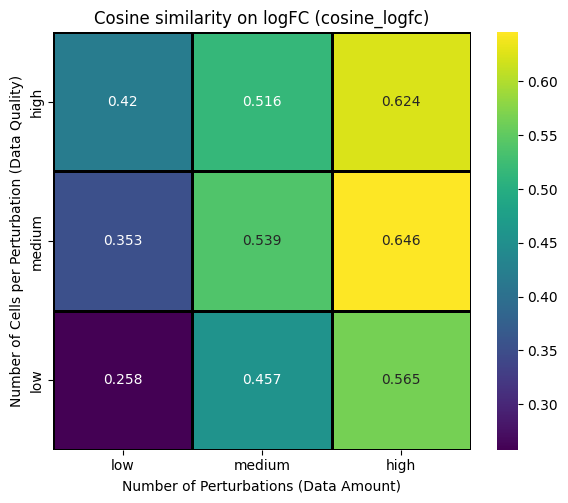

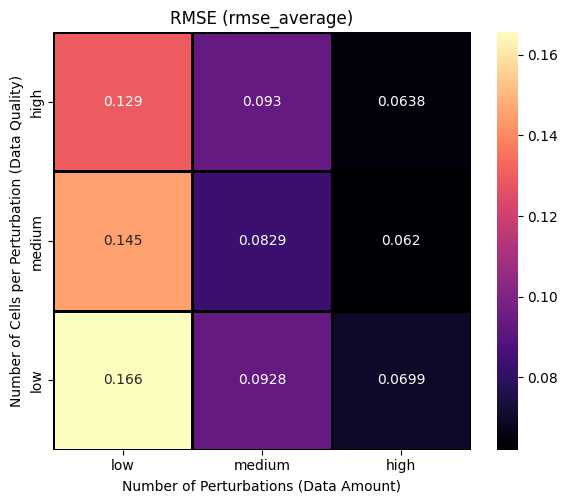

In [2]:


# --------- CONFIGURE YOUR GRID LABELS HERE ----------
x_labels = ["low", "medium", "high"]      # Training Data Amount (columns)
y_labels = ["high", "medium", "low"]      # Data Quality (rows)

# Path pattern (as you provided)
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/*_boli*/evaluation/summary.csv"
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-22_15-59-22/*_boli*/evaluation/summary.csv"
PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/*_replogle*/evaluation/summary.csv"

# Optional: if your run dirs encode amount/quality with these tokens; adjust if needed.
AMOUNT_RE  = re.compile(r"(?:amount|train|split|size|amt|data|cells)[-_]?(low|medium|high)", re.I)
QUALITY_RE = re.compile(r"(?:quality|qual|noise|q)[-_]?(low|medium|high)", re.I)

# --------- HELPERS ----------
def find_label_in_text(text, labels):
    """Return first matching label in `labels` found as whole word in text (case-insensitive)."""
    for lab in labels:
        if re.search(rf"\b{re.escape(lab)}\b", text, flags=re.I):
            return lab
    return None

def parse_xy_from_path(path):
    """
    Infer (x_amount, y_quality) from the run directory name.
    Tries explicit regex first; falls back to scanning labels in the path.
    """
    run_dir = os.path.dirname(path)
    print(path)
    base = os.path.basename(run_dir)

    m_amt = AMOUNT_RE.search(run_dir) or AMOUNT_RE.search(base)
    m_qual = QUALITY_RE.search(run_dir) or QUALITY_RE.search(base)

    x = (m_amt.group(1).lower() if m_amt else None)
    y = (m_qual.group(1).lower() if m_qual else None)

    # Fallbacks: try to spot labels anywhere in the path
    if x is None:
        x = find_label_in_text(run_dir, x_labels)
    if y is None:
        y = find_label_in_text(run_dir, y_labels)

    return x, y

# --------- LOAD CSVs & PLACE INTO MATRICES ----------
paths = sorted(glob.glob(PATTERN))

# Initialize matrices with NaN so missing cells remain blank
mat_cos = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_rmse = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)

for p in paths:
    x, y = parse_xy_from_path(p)
    if (x not in x_labels) or (y not in y_labels):
        print(f"[warn] Could not map run to grid (x={x}, y={y}) for: {p}")
        continue

    df = pd.read_csv(p)
    # Expect a 2-column CSV like:
    # metric,LatentAdditive
    # rmse_average,0.1496
    # cosine_logfc,0.44
    if df.shape[1] < 2:
        print(f"[warn] Unexpected CSV shape for {p}: {df.shape}")
        continue

    value_col = df.columns[1]  # e.g., "LatentAdditive"
    sub = df.set_index("metric")[value_col]

    if "cosine_logfc" in sub.index:
        mat_cos.loc[y, x] = float(sub["cosine_logfc"])
    else:
        print(f"[warn] cosine_logfc missing in {p}")

    if "rmse_average" in sub.index:
        mat_rmse.loc[y, x] = float(sub["rmse_average"])
    else:
        print(f"[warn] rmse_average missing in {p}")

# --------- PLOT HEATMAPS ----------
def plot_heatmap(data, title, cmap="viridis", fmt=".3g"):
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        data,
        annot=True, fmt=fmt, linewidths=1, linecolor="black",
        square=True, cmap=cmap, cbar=True
    )
    ax.set_xlabel("Number of Perturbations (Data Amount)")
    ax.set_ylabel("Number of Cells per Perturbation (Data Quality)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(mat_cos,  "Cosine similarity on logFC (cosine_logfc)")
plot_heatmap(mat_rmse, "RMSE (rmse_average)", cmap="magma")